<a href="https://colab.research.google.com/github/Jihaad2021/NLP_Practice/blob/main/Text_Classification/01_Text_Classification_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 

import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words 

import string 
import re 

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn import metrics 

from time import time

In [4]:
## Load Data 
our_data = pd.read_csv("https://raw.githubusercontent.com/Jihaad2021/NLP_Practice/main/Data/Full-Economic-News-DFE-839861.csv")
our_data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [5]:
our_data.shape

(8000, 15)

In [6]:
our_data.relevance.value_counts()/our_data.shape[0]

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [7]:
# imbalance data problem 

In [8]:
# conver data to numerical 
our_data = our_data[our_data.relevance != "not sure"]
our_data.shape
our_data['relevance'] = our_data.relevance.map({"yes":1, "no":0})
our_data = our_data[["text", "relevance"]]
our_data.shape

(7991, 2)

In [9]:
## 2. Text preprocessing

In [14]:
stopwords = _stop_words.ENGLISH_STOP_WORDS
def clean(doc):
  doc = doc.replace("</br>", " ")
  doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
  doc = " ".join([token for token in doc.split() if token not in stopwords])
  return doc

In [11]:
## 3. Modeling 

In [15]:
import sklearn 
from sklearn.model_selection import train_test_split

X = our_data.text 
y = our_data.relevance
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [17]:
vect = CountVectorizer(preprocessor=clean)
X_train_dtm = vect.fit_transform(X_train)

X_test_dtm = vect.transform(X_test) 
print(X_train_dtm.shape, X_test_dtm.shape)

(5993, 48473) (1998, 48473)


In [18]:
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 19.7 ms


## 1. Naive Bayes

Accuracy:  0.7787787787787788
ROC_AUC_Score:  0.7242730669265756


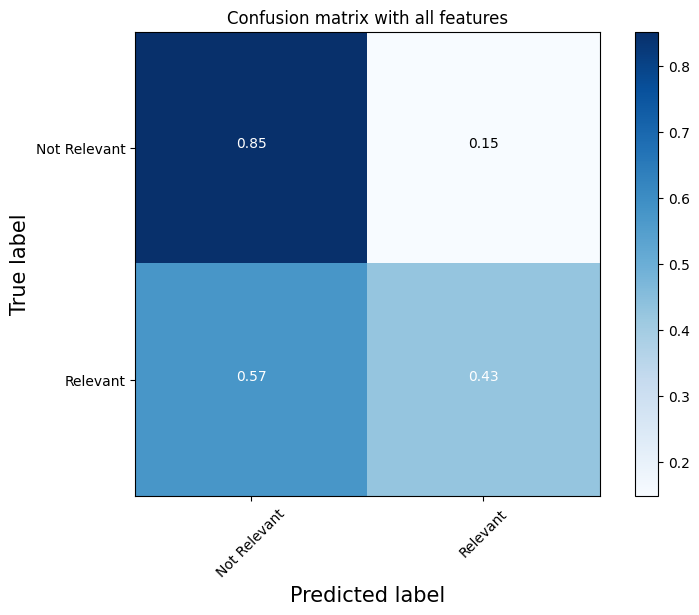

In [24]:
import itertools
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True.
  """
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
  
  plt.tight_layout()
  plt.ylabel('True label', fontsize=15)
  plt.xlabel('Predicted label', fontsize=15)

print("Accuracy: ", accuracy_score(y_test, y_pred_class))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, 
                      classes=["Not Relevant", "Relevant"], 
                      normalize=True, 
                      title="Confusion matrix with all features")

y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AUC_Score: ", roc_auc_score(y_test, y_pred_prob))


CPU times: user 5.57 ms, sys: 0 ns, total: 5.57 ms
Wall time: 5.72 ms
Accuracy:  0.6876876876876877


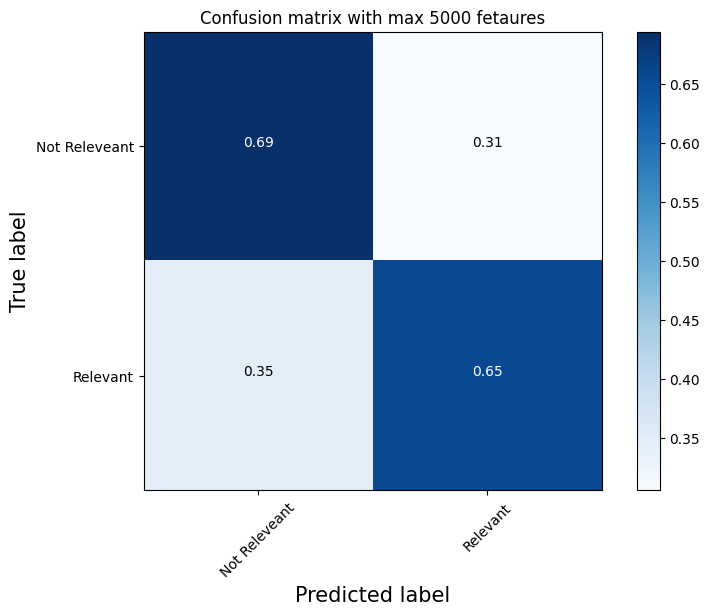

In [25]:
vect = CountVectorizer(preprocessor=clean, max_features=5000)

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

nb=MultinomialNB()

%time nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=["Not Releveant", "Relevant"], 
                      normalize=True, 
                      title='Confusion matrix with max 5000 fetaures')

## 2. Logistic Regression

Accuracy:  0.7347347347347347
AUC:  0.7242730669265756


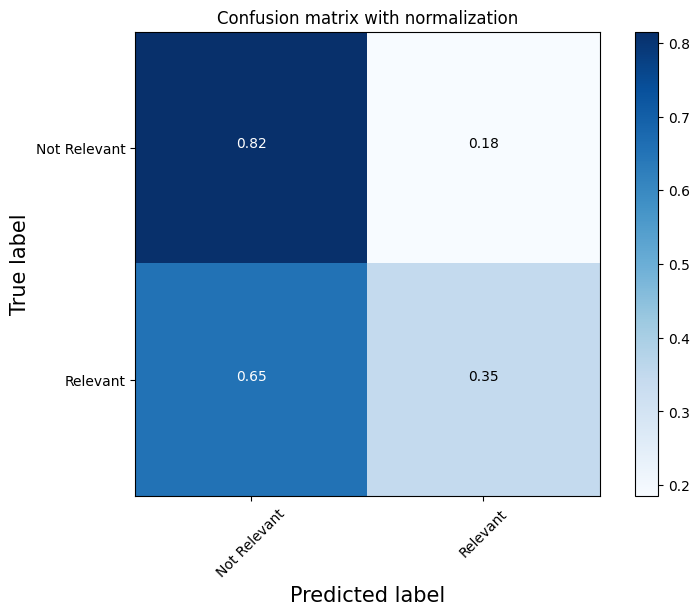

In [35]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train_dtm, y_train)

y_pred_class = logreg.predict(X_test_dtm)

print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=["Not Relevant", "Relevant"],
                      normalize=True,
                      title="Confusion matrix with normalization")



## 3. SVM

Accuracy:  0.7172172172172172
AUC:  0.7242730669265756


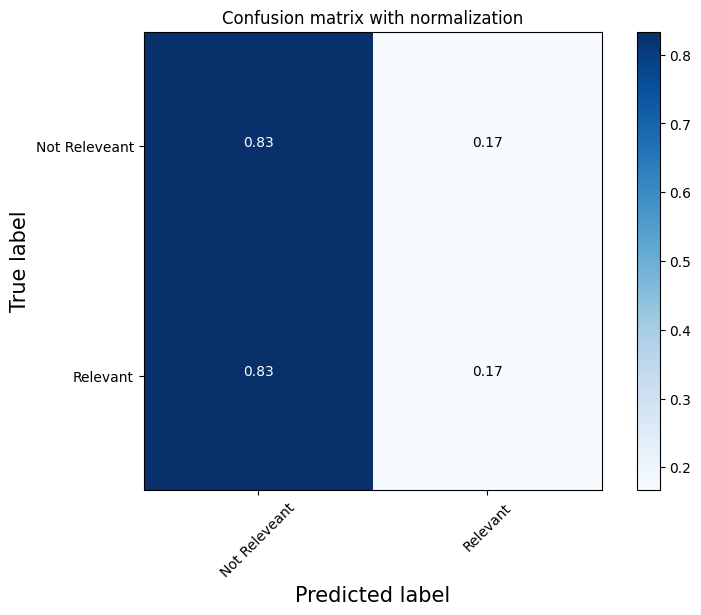

In [36]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.fit_transform(X_test)

classifier =  LinearSVC(class_weight='balanced') 
classifier.fit(X_train_dtm, y_train) 

y_pred_class = classifier.predict(X_test_dtm)

print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class) 

plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=["Not Releveant", "Relevant"], 
                      normalize=True, 
                      title='Confusion matrix with normalization')
